# Analyzing Netflix Dataset With Python

(Part-1)

### Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style

import os
import re

%matplotlib inline

### Set default options

In [2]:
pd.options.display.max_colwidth = 100
plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 14

style.use('tableau-colorblind10')

### Read and explore Netflix dataset

In [3]:
# directory that contains netflix dataset
net_dir = os.getcwd() + "\\Netflix_Dataset\\"

# zip file containing netflix dataset
net_zipfile = "Netflix_Titles.zip"

# Read the file and save in raw dataframe
netflix_raw_data = pd.read_csv(net_dir + net_zipfile)

#### dataframe.info() and dataframe.describe()

In [4]:
# info and describe raw dataframe
netflix_raw_data.info()

pd.options.display.float_format = "{:.0f}".format
netflix_raw_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


,release_year
count,7787
mean,2014
std,9
min,1925
25%,2013
50%,2017
75%,2018
max,2021


In [5]:
# reset float format
pd.options.display.float_format = "{:.3f}".format

#### Duplicate rows?

In [6]:
# check for any duplicate records
print("No. of duplicated records (if any):", netflix_raw_data.duplicated().sum())

No. of duplicated records (if any): 0


#### Content type

In [7]:
# content category
netflix_raw_data["type"].value_counts()

Movie      5377
TV Show    2410
Name: type, dtype: int64

### Sample rows

In [8]:
# set some display options
pd.options.display.max_colwidth = 50
pd.options.display.max_columns = 20

# sample rows from netflix dataset
netflix_raw_data.iloc[7748: 7754, :]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7748,s7749,Movie,الف مبروك,Ahmed Nader Galal,"Ahmed Helmy, Laila Ezz El Arab, Mahmoud El Fis...",Egypt,"April 25, 2020",2009,TV-14,115 min,"Comedies, Dramas, International Movies","On his wedding day, an arrogant, greedy accoun..."
7749,s7750,TV Show,Yu-Gi-Oh!,NaN,"Dan Green, Eric Stuart, Amy Birnbaum, Darren D...",Japan,"July 8, 2020",2005,TV-Y7,2 Seasons,"Anime Series, Kids' TV",The lives of young Yugi Moto and his friends J...
7750,s7751,TV Show,Yu-Gi-Oh! Arc-V,NaN,"Mike Liscio, Emily Bauer, Billy Bob Thompson, ...","Japan, Canada","May 1, 2018",2015,TV-Y7,2 Seasons,"Anime Series, Kids' TV",Now that he's discovered the Pendulum Summonin...
7751,s7752,Movie,Yucatán,Daniel Monzón,"Luis Tosar, Rodrigo de la Serna, Joan Pera, St...",Spain,"February 15, 2019",2018,TV-MA,130 min,"Comedies, International Movies",Competing con artists attempt to creatively an...
7752,s7753,TV Show,Yummy Mummies,NaN,"Lorinska Merrington, Jane Scandizzo, Rachel Wa...",Australia,"July 3, 2019",2019,TV-MA,2 Seasons,"International TV Shows, Reality TV",It's drama Down Under when expectant mothers w...
7753,s7754,TV Show,Yunus Emre,NaN,"Gökhan Atalay, Payidar Tüfekçioglu, Baran Akbu...",Turkey,"January 17, 2017",2016,TV-PG,2 Seasons,"International TV Shows, TV Dramas","During the Mongol invasions, Yunus Emre leaves..."


### Table for columns with Missing Values

In [9]:
# this block of code only displays columns which have missing data and the % of rows with the missing values
null_column_list = []

# total no. of rows in dataset
total_rows = netflix_raw_data.shape[0]

for each_col in netflix_raw_data.columns:
    if netflix_raw_data[each_col].isnull().sum() > 0:
        null_sum = netflix_raw_data[each_col].isnull().sum()
        null_perc = "{:.4f}".format(null_sum / total_rows * 100)
        
        null_column_list.append([each_col, null_sum, null_perc])
                
# display missing row count and % as a dataframe    
pd.DataFrame(null_column_list, columns = ["Column Name", "No. of rows with missing values", 
                                          "Missing value as % (Netflix Dataset)"])

,Column Name,No. of rows with missing values,Missing value as % (Netflix Dataset)
0,director,2389,30.6793
1,cast,718,9.2205
2,country,507,6.5109
3,date_added,10,0.1284
4,rating,7,0.0899


In [10]:
# delete the dummy variables        
del total_rows, null_column_list

## Explore Netflix Dataset

### type Column

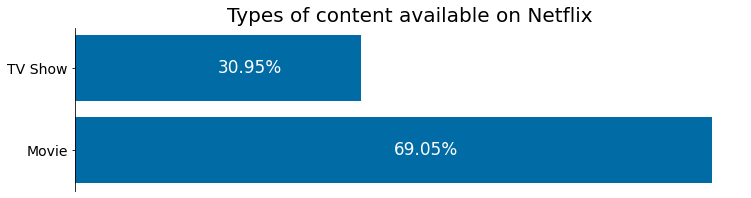

In [11]:
# create figure
fig, ax = plt.subplots(figsize = (12,3))

# plot content type as percentage
ax.barh(y = netflix_raw_data["type"].value_counts(normalize = True).index,
       width = netflix_raw_data["type"].value_counts(normalize = True).mul(100).values)

# set title for the plot 
ax.set_title("Types of content available on Netflix")

# hide the x-axis ticks and labels
ax.set_xticklabels(labels = "")
ax.tick_params(bottom = False)

# annotate each bar
for p in ax.patches:
    ax.annotate(text = "{:.2f}%".format(p.get_width()), 
                xy = [p.get_width()/ 2, p.get_y() + 0.35], 
                color = "white", fontsize = "large")
    
# despine the plot
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine != "left"]

# show the plot
plt.show()    

### rating Column

In [12]:
# identify the titles with missing-values
netflix_raw_data.loc[netflix_raw_data["rating"].isnull(), ["title", "director", "release_year", "rating"]]

,title,director,release_year,rating
67,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,2017,NaN
2359,Gargantia on the Verdurous Planet,NaN,2013,NaN
3660,Little Lunch,NaN,2015,NaN
3736,Louis C.K. 2017,Louis C.K.,2017,NaN
3737,Louis C.K.: Hilarious,Louis C.K.,2010,NaN
3738,Louis C.K.: Live at the Comedy Store,Louis C.K.,2015,NaN
4323,My Honor Was Loyalty,Alessandro Pepe,2015,NaN


#### Mapper for titles with missing values

In [13]:
# dictionary to map title with ratings (Copied from Mike's work)
ratings_map = {idx:val for idx,val in zip(netflix_raw_data.loc[netflix_raw_data["rating"].isnull(), "title"].values, 
                                          ["TV-PG", "TV-14", "TV-Y7", "TV-MA", "TV-MA", "TV-MA", "PG-13"])}
# display ratings dictionary
ratings_map

{'13TH: A Conversation with Oprah Winfrey & Ava DuVernay': 'TV-PG',
 'Gargantia on the Verdurous Planet': 'TV-14',
 'Little Lunch': 'TV-Y7',
 'Louis C.K. 2017': 'TV-MA',
 'Louis C.K.: Hilarious': 'TV-MA',
 'Louis C.K.: Live at the Comedy Store': 'TV-MA',
 'My Honor Was Loyalty': 'PG-13'}

In [14]:
# replace the missing ratings
netflix_raw_data["rating"] = netflix_raw_data["title"].map(ratings_map).fillna(netflix_raw_data["rating"])

In [15]:
# import pywaffle
from pywaffle import Waffle

In [16]:
# temp variable for value count of ratings for Netflix Movies
data1 = dict(netflix_raw_data[netflix_raw_data["type"] == "Movie"]
            ["rating"].value_counts())

# temp variable for value count of ratings for Netflix TV Shows
data2 = dict(netflix_raw_data[netflix_raw_data["type"] != "Movie"]
            ["rating"].value_counts()) 

C:\ProgramData\Anaconda3\lib\site-packages\pywaffle\waffle.py:394: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  self.ax = self.add_subplot(loc, aspect="equal")


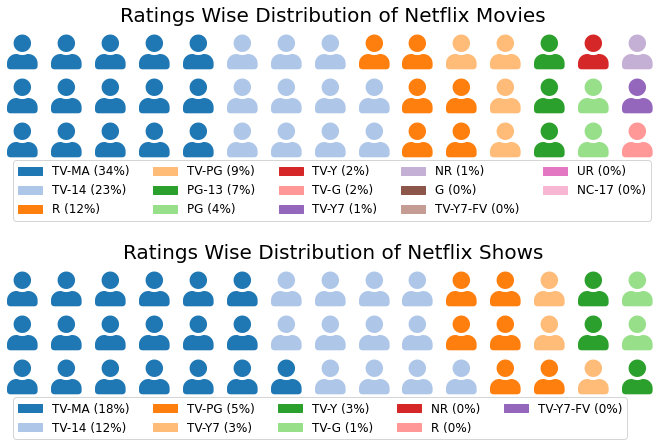

In [17]:
# make pywaffle chart with 2 subplots for each type of Netflix Content
fig = plt.figure(
    FigureClass = Waffle,
    plots = {
        '211': 
        {'values': data1,
         'labels' : [f"{k} ({int(v / sum(data1.values()) * 100)}%)" for k, v in data1.items()],
         'legend': {
             'loc': 'lower left',
             'bbox_to_anchor': (0, -0.6),
             'fontsize': 12, 
             'ncol': 5},
         'title' : {"label" : "Ratings Wise Distribution of Netflix Movies"}
        },
        '212': 
        {'values': data2,
         'labels' : [f"{k} ({int(v / sum(data1.values()) * 100)}%)" for k, v in data2.items()],
         'legend': {
             'loc': 'lower left',
             'bbox_to_anchor': (0, -0.45),
             'fontsize': 12, 
             'ncol': 5},
         'title' : {"label" : "Ratings Wise Distribution of Netflix Shows"}
        }
    },
    rows = 3,
    columns = 15,
    icons = "user",
    cmap_name = "tab20",
    figsize = (14, 6.5)
)    
plt.tight_layout(h_pad = 0)
plt.show()

### date_added Column & release Column

In [18]:
# convert date_added column to a datetime format
netflix_raw_data["date_added"] = pd.to_datetime(netflix_raw_data["date_added"])

# select only those records where date_added column has values
netflix_raw_data = netflix_raw_data[netflix_raw_data["date_added"].notna()]

# shape of resultant netflix_raw_data
netflix_raw_data.shape

(7687, 12)

#### Additional Analysis

This is a small analysis of:
- distribution of titles based on the decade they were released
- distribution of titles hosted by Netflix since it's inception

For ease of plotting:
- the titles that were released before the year 1980, have been grouped under `Before 1980`. Why this year? because I was born in this decade!
- since Netflix established itself in 190 countries by 2016, all the titles added (on Netflix platform) before 2016 have been grouped under `Added before 2016`.

In [19]:
# calculate the decade for each year of release
decade_df = (netflix_raw_data["release_year"] // 10 * 10).value_counts().reset_index()

# rename the dataframe columns
decade_df.rename(columns = {"index": "Decade", "release_year" : "No. of Titles"}, inplace = True)

# identify titles released before the year 1980 
decade_df["Decade"] = decade_df["Decade"].apply(lambda d: d if d > 1970 else "Before 1980")

# label each decade as YYYY's
decade_df["Decade"] = decade_df["Decade"].astype(str).apply(lambda s: s + "'s")

In [20]:
# group the no. of titles by decade in which they were released
data1 = decade_df.groupby("Decade")["No. of Titles"].sum()

# group the no. of titles by decade in which they were added to Netflix
data2 = netflix_raw_data["date_added"].dt.year.apply(lambda d: "In " + str(d) if d > 2015 else "Before 2016").\
        value_counts().sort_index()

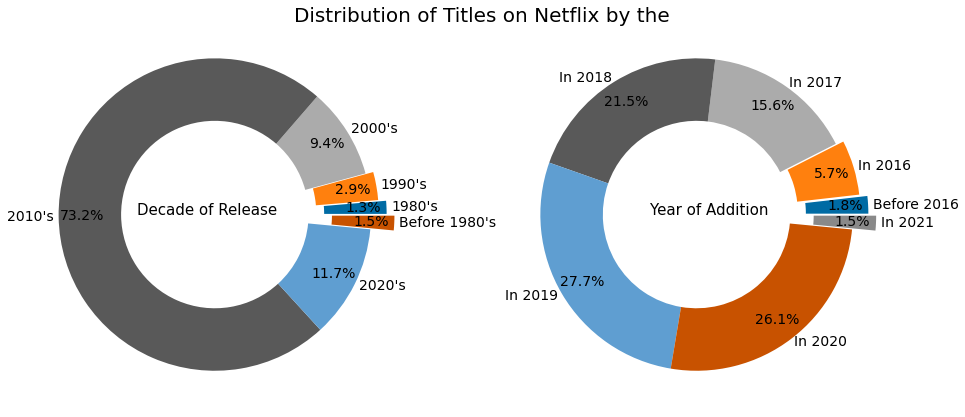

In [21]:
# create figure object
fig, ax = plt.subplots(ncols = 2, figsize = (13.5, 6))

# plot the years when title was released
ax[0].pie(x = data1.values, 
          labels = data1.index,
          labeldistance = 1.03,
          autopct = "%.1f%%",
          explode = [0.1, 0.05, 0, 0, 0, 0.15],
          pctdistance = 0.85,
          startangle = 0, 
          wedgeprops = {"width": 0.4}) 

# annotation in the center
ax[0].annotate(text = "Decade of Release", xy = (-0.5,0), fontsize = 15)

# plot the years when title was added
ax[1].pie(x = data2.values,
          labels = data2.index,
          labeldistance = 1.03,
          autopct = "%.1f%%",
          explode = [0.1, 0.05, 0, 0, 0, 0, 0.15],
          pctdistance = 0.85,
          startangle = 0,
          rotatelabels = False, 
          wedgeprops = {"width": 0.4})

# annotation in the center
ax[1].annotate(text = "Year of Addition", xy = (-0.3,0), fontsize = 15)

# extras 
# plt.subplots_adjust(wspace = 0.2, hspace = 0)
plt.tight_layout(pad = 1)
plt.suptitle(t = "Distribution of Titles on Netflix by the", fontsize = 20)

# show plot
plt.show()

In [22]:
# delete non-essential variables
del decade_df, data1, data2

### duration Column

This column specifies the duration of a title in No. of seasons or runtime in minutes. However, if we analyze the values, the TV Shows are specified with seasons and Movies have runtime minutes. No series has runtime in minutes.

In [23]:
# title type with duration in seasons
print(netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("Season"), "type"].value_counts(), "\n")

# title type with duration in minutes
print(netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "type"].value_counts())

TV Show    2330
Name: type, dtype: int64 

Movie    5357
Name: type, dtype: int64


In [24]:
# duration for title type TV Show 
netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("Season"), "duration"].value_counts()

1 Season      1596
2 Seasons      357
3 Seasons      165
4 Seasons       83
5 Seasons       54
6 Seasons       28
7 Seasons       16
8 Seasons       13
9 Seasons        7
10 Seasons       4
12 Seasons       2
15 Seasons       2
13 Seasons       1
16 Seasons       1
11 Seasons       1
Name: duration, dtype: int64

### Visualize distribution of seasons for titles on netflix

In [25]:
# temporary variable
data = netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("Season")]["duration"].value_counts()

# group seasons to accommodate in a pie-chart
for each in data.index:
    if int(each.split()[0]) < 6:
        pass
    elif int(each.split()[0]) <= 8:
        data.rename({each : "As long as GOT"}, inplace = True)
    elif int(each.split()[0]) <= 10:
        data.rename({each : "As long as F.R.I.E.N.D.S"}, inplace = True)
    else:
        data.rename({each : "Too long"}, inplace = True)

# re-group and total
data = data.groupby(data.index).sum()

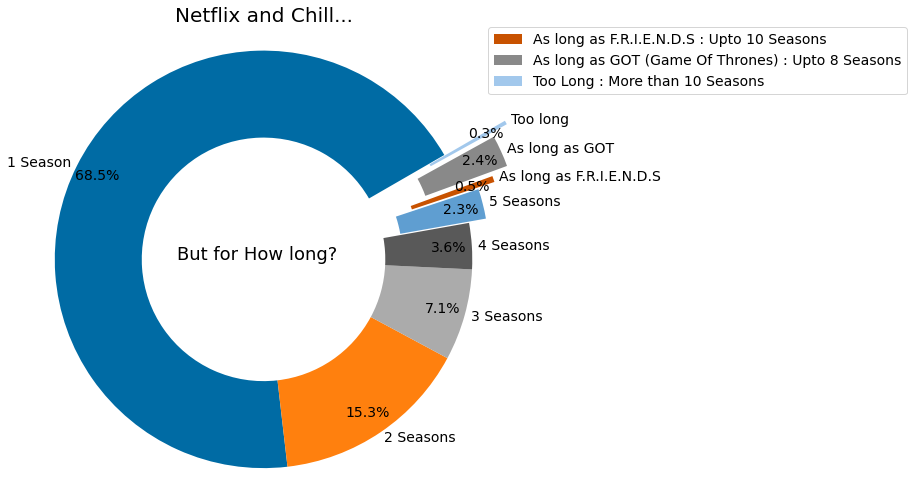

In [26]:
# create a figure object
fig, ax = plt.subplots(figsize = (12, 8))

# draw a pie-chart
ax.pie(x = data,
       labels = data.index,
       autopct = "%.1f%%",
       pctdistance = 0.89,
       explode = [0, 0, 0, 0, 0.1, 0.2, 0.3, 0.4],
       labeldistance = 1.03,
       startangle = 30, 
       radius = 1.2,
       wedgeprops = {"width": 0.5})

# set title for the plot
ax.set_title("Netflix and Chill...", pad = 20)
ax.annotate(text = "But for How long?", xy = (-0.5, 0), fontsize = "18")

## Custom legend for grouped items
# handler map
handler_map = {"As long as F.R.I.E.N.D.S" : "Upto 10 Seasons", 
               "As long as GOT (Game Of Thrones)" : "Upto 8 Seasons", 
               "Too Long" : "More than 10 Seasons"}

# get default the handles and labels
handles, labels = ax.get_legend_handles_labels()

# place only the last three handles which have grouped seasons 
ax.legend(handles = handles[-3:], 
          labels = (" : ".join([k,v]) for k,v in handler_map.items()), 
          bbox_to_anchor = (1, 1.05))

# show the plot
plt.show()

In [27]:
# delete temporary/intermediate variables
del data

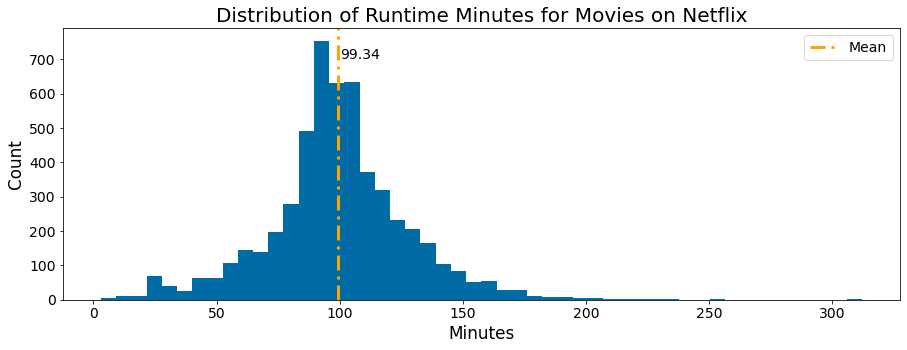

In [28]:
# create figure object
fig, ax = plt.subplots()

# distribution of runtime in minutes
ax.hist(x = netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "duration"].\
        str.strip("min").astype(int), 
        bins = 50)

# draw vertical line - mean runtime for movies
ax.axvline(x = netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "duration"].\
           str.strip("min").astype(int).mean(),
           lw = 3,
           dashes = [5, 2, 1, 2],
           color = "orange", 
           label = "Mean")

# annotation
ax.annotate(text = "{:.2f}".format(netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "duration"].\
           str.strip("min").astype(int).mean()), 
            xy = [100, 700])

# extras 
ax.legend()
ax.set_title("Distribution of Runtime Minutes for Movies on Netflix")
ax.set_ylabel("Count", fontsize = "large")
ax.set_xlabel("Minutes", fontsize = "large")

# show plot
plt.show()

## Tackle the Missing Values

The big bad boy: Missing Values in 3 columns - Director, Cast and Country of origin of a title. 
The idea is to try out the best approach possible and fill-in as many missing values as we can.

Why IMDB? [IMDB.com](https://www.imdb.com/) provides separate datasets with different information. The common link between these datasets are alpha-numeric columns like "tconst", "nconst" etc. that provide unique identifiers for a title/ cast/ crew member.

### Split the Netflix dataset into 2 separate dataframes

- <b>netflix_data :</b> dataframe with non-null values for all the columns
- <b>missing_data :</b> dataframe with rows where values for any of the 3 columns is missing

In [29]:
"""split the dataframe with missing and non-missing values"""

# non-null data
netflix_data = netflix_raw_data[(netflix_raw_data["director"].notna()) &
                                (netflix_raw_data["cast"].notna()) &
                                (netflix_raw_data["country"].notna())].reset_index(drop = True)

# where data for either of the 3 columns - director, cast and country is missing
missing_data = netflix_raw_data[netflix_raw_data["director"].isnull() | 
                                netflix_raw_data["cast"].isnull() |
                                netflix_raw_data["country"].isnull()].reset_index(drop = True)

In [30]:
# shape of resultant datasets
print("Dataframe Name: (Rows, Columns)", 
      "-".rjust(30, "-"),
      "Data with Nulls: " + str(missing_data.shape),
      "Non-null data: " + str(netflix_data.shape), sep = "\n")

Dataframe Name: (Rows, Columns)
------------------------------
Data with Nulls: (2897, 12)
Non-null data: (4790, 12)


In [31]:
missing_data[["director", "cast", "country"]].isnull().sum()

director    2314
cast         709
country      503
dtype: int64

### Concatenate the title and release_year columns in missing_data dataframes

In order to compare the Netflix dataset and datasets provided by IMDB, 

- special or non-alphanumeric characters have been removed from title names
- lower case has been applied to all the title names
- underscore has been added between title and year values while concatenation

In [32]:
# combination of title and release_year columns
missing_data["combo"] = missing_data["title"].str.replace(r"[^\w\s]+", "", regex = True).str.lower().\
                             str.cat(missing_data["release_year"].astype(str), sep = "_")

# sample rows with selected columns only 
missing_data[["title", "release_year", "combo", "director", "cast", "country"]].head(10)

,title,release_year,combo,director,cast,country
0,3%,2020,3_2020,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil
1,1983,2018,1983_2018,NaN,"Robert Więckiewicz, Maciej Musiał, Michalina O...","Poland, United States"
2,1994,2019,1994_2019,Diego Enrique Osorno,NaN,Mexico
3,Feb-09,2018,feb09_2018,NaN,"Shahd El Yaseen, Shaila Sabt, Hala, Hanadi Al-...",NaN
4,'89,2017,89_2017,NaN,"Lee Dixon, Ian Wright, Paul Merson",United Kingdom
5,​SAINT SEIYA: Knights of the Zodiac,2020,saint seiya knights of the zodiac_2020,NaN,"Bryson Baugus, Emily Neves, Blake Shepard, Pat...",Japan
6,(T)ERROR,2015,terror_2015,"Lyric R. Cabral, David Felix Sutcliffe",NaN,United States
7,(Un)Well,2020,unwell_2020,NaN,NaN,United States
8,#blackAF,2020,blackaf_2020,NaN,"Kenya Barris, Rashida Jones, Iman Benson, Genn...",United States
9,#cats_the_mewvie,2020,cats_the_mewvie_2020,Michael Margolis,NaN,Canada


### Read IMDB datasets

In [33]:
# Set-up directory and Files
imdb_dir = os.getcwd() + "\\IMDB_Dataset\\"
imdb_file_names = ["title_akas.tsv", "title_basics.tsv", "title_crew.tsv", "title_principals.tsv", "name_basics.tsv"]

In [34]:
# import the IMDB_work.py module aliased as "iw" for now
import IMDB_work as iw

In [35]:
print("Docstring for the module and function", "\n")
print(iw.__doc__)
print(iw.read_imdb_files.__doc__)

Docstring for the module and function 

python module to read and store IMDB Data Files in pandas dataframe 

Function to read the ".tsv" files downloaded from IMDB interface
----------------------------------------------------------------
Name: read_imdb_files

Parameters: 
- file_name: name of the IMDB dataset file. 
- file_directory: name of the directory that contains the IMDB dataset files. Parameter has been set to default option.

Returns: a dataframe containing all the records of the IMDB dataset file with every column stored as "object" dtype

Additional Info: 
- all the fields are stored as object dtype to avoid any errors 
- prints the shape and missing value % for the datafile

- "\N" represents missing or null values in IMDB datasets. These have been replaced with np.nan. 
    


In [36]:
""" Read the title_basics.tsv file """
title_basics = iw.read_imdb_files(file_name = imdb_file_names[1], file_directory = imdb_dir)

The data file title_basics.tsv contains 7918519 rows and 9 columns
       ColumnName  MissingValue%
0          tconst          0.000
1       titleType          0.000
2    primaryTitle          0.000
3   originalTitle          0.000
4         isAdult          0.000
5       startYear         10.950
6         endYear         99.030
7  runtimeMinutes         72.080
8          genres          7.810


In [37]:
""" Read the name_basics.tsv file """
name_basics = iw.read_imdb_files(file_name = imdb_file_names[-1], file_directory = imdb_dir)

The data file name_basics.tsv contains 10942043 rows and 6 columns
          ColumnName  MissingValue%
0             nconst          0.000
1        primaryName          0.000
2          birthYear         95.190
3          deathYear         98.270
4  primaryProfession         21.230
5     knownForTitles         18.520


In [38]:
""" Read the title_crew.tsv file """
title_crew = iw.read_imdb_files(file_name = imdb_file_names[2], file_directory = imdb_dir)

The data file title_crew.tsv contains 7918519 rows and 3 columns
  ColumnName  MissingValue%
0     tconst          0.000
1  directors         42.420
2    writers         49.180


In [39]:
"""Read title_principals.tsv file"""
title_principals = iw.read_imdb_files(file_name = imdb_file_names[3], file_directory = imdb_dir)

The data file title_principals.tsv contains 44887359 rows and 6 columns
   ColumnName  MissingValue%
0      tconst          0.000
1    ordering          0.000
2      nconst          0.000
3    category          0.000
4         job         83.900
5  characters         49.970


### Finding Common Titles

In [40]:
# combination of primaryTitle and startYear columns >> title_basics dataset
title_basics["combo"] = title_basics["primaryTitle"].str.replace(r"[^\w\s]+", "", regex = True).str.lower().\
                        str.cat(title_basics["startYear"].astype(str), sep = "_")

In [41]:
# sample rows from title_basics dataframe
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,combo
0,tt0000001,short,Carmencita,Carmencita,0,1894,NaN,1,"Documentary,Short",carmencita_1894
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,NaN,5,"Animation,Short",le clown et ses chiens_1892
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,NaN,4,"Animation,Comedy,Romance",pauvre pierrot_1892
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,NaN,12,"Animation,Short",un bon bock_1892
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,NaN,1,"Comedy,Short",blacksmith scene_1893


In [42]:
"""
- match the combination in title_basics and missing_data dataframes
- collect and store the matched records in a temporary dataframe - match_df
"""

all_matches_df = title_basics.loc[title_basics["combo"].isin(missing_data["combo"]), 
                                  ["tconst", "combo"]].reset_index(drop = True).\
                                  groupby("combo")["tconst"].unique().reset_index()

# sample rows from resultant match_df dataframe
print("Shape:", all_matches_df.shape)
all_matches_df.head()

Shape: (1750, 2)


,combo,tconst
0,100 days my prince_2018,[tt8199972]
1,100 things to do before high school_2014,"[tt3904078, tt3914888]"
2,12 years promise_2014,[tt5476252]
3,13 reasons why_2020,[tt12301534]
4,13th a conversation with oprah winfrey ava du...,[tt6491068]


In [43]:
# filter out unique title names i.e. no other title of the same name was released at any other time
all_matches_df = all_matches_df[all_matches_df["tconst"].str.len() == 1].\
                 set_index("combo").explode("tconst").reset_index()

# shape of resultant match_df
print(all_matches_df.shape)

# keep all_macthes_df as backup and create a dataframe for intermediate steps
match_df = all_matches_df.copy()

(1386, 2)


### Finding Missing Director

In [44]:
"""
- match the tconst ID between the match_df and title_crew dataset
- extract director ID's associated with a title from title_crew dataframe
"""
# match the title ID and map the director ID in match_df dataframe
match_df["director_id"] = match_df["tconst"].map(dict(title_crew.loc[title_crew["tconst"].isin(match_df["tconst"]), 
                                                                     ["tconst", "directors"]].dropna().values))

"""
- the title_crew dataset itself has null values. matches with these records won't help us
- so we drop the records where director ID column still contains null
"""

# drop null values
match_df.dropna( inplace = True) #subset = ["director_id"],

# reset the index for match_df to linear >> 0,...,n-1
match_df.reset_index(drop = True, inplace = True)

# sample rows from resultant match_df
print(match_df.shape) 

match_df.tail(10)

(1178, 3)


,combo,tconst,director_id
1168,your excellency_2019,tt11489288,nm2481000
1169,your lie in april_2014,tt3895150,"nm4733902,nm3440248,nm4796122,nm1841039,nm4303..."
1170,yours fatefully_2012,tt7131690,"nm11522613,nm11522614,nm6562612"
1171,z nation_2018,tt8395332,nm7914806
1172,z4_2018,tt8618456,nm0872780
1173,zak storm_2016,tt4209752,nm3569481
1174,zindagi gulzar hai_2012,tt2828240,nm5616300
1175,zoids wild_2018,tt12317724,nm0837219
1176,zona rosa_2019,tt11194518,nm10743407
1177,zz top that little ol band from texas_2019,tt9015306,nm0242757


In [45]:
"""Since we collected multiple directors as comma separated values 
we will explode these ID's so that we get one director ID per row."""

# split the director ID by ","
match_df["director_id"] = match_df["director_id"].str.split(",")

# explode on director ID column to get dataframe with each in separate row
match_df = match_df.set_index(["combo", "tconst"]).explode("director_id").reset_index()

# sample rows from resultant match_df 
match_df.tail(10)

,combo,tconst,director_id
2570,yours fatefully_2012,tt7131690,nm11522613
2571,yours fatefully_2012,tt7131690,nm11522614
2572,yours fatefully_2012,tt7131690,nm6562612
2573,z nation_2018,tt8395332,nm7914806
2574,z4_2018,tt8618456,nm0872780
2575,zak storm_2016,tt4209752,nm3569481
2576,zindagi gulzar hai_2012,tt2828240,nm5616300
2577,zoids wild_2018,tt12317724,nm0837219
2578,zona rosa_2019,tt11194518,nm10743407
2579,zz top that little ol band from texas_2019,tt9015306,nm0242757


In [46]:
"""Match the director ID with nconst column in Name Basics dataset and extract the name of the director"""

# match the director ID and nconst columns
matched_names = name_basics.loc[name_basics["nconst"].isin(match_df["director_id"]), ["nconst", "primaryName"]].values

# map the names of directors
match_df["director_name"] = match_df["director_id"].map(dict(matched_names))

# sample rows from resultant match_df 
match_df.tail()

,combo,tconst,director_id,director_name
2575,zak storm_2016,tt4209752,nm3569481,Philippe Guyenne
2576,zindagi gulzar hai_2012,tt2828240,nm5616300,Sultana Siddiqui
2577,zoids wild_2018,tt12317724,nm0837219,Norihiko Sutô
2578,zona rosa_2019,tt11194518,nm10743407,Alex Díaz
2579,zz top that little ol band from texas_2019,tt9015306,nm0242757,Sam Dunn


This is a reverse process to short our long dataframe into a wide one by grouping (multiple if present) director(s) based on a title.

In [47]:
# group the directors by title ID
match_df = match_df.groupby("combo")["director_name"].apply(lambda s: ",".join(s)).reset_index()

# How many missing directors have we been able to identify?
match_df.shape

(1178, 2)

In [48]:
# replace the missing_directors; this will be later appended to netflix non null dataset
missing_data.loc[missing_data["director"].isnull(), 
                 "director"] = missing_data.loc[missing_data["director"].isnull(), 
                                                "combo"].map(dict(match_df.values)).fillna("Unknown")

In [49]:
# have we been able to reduce the missing value count for "director" column
missing_data[["director", "cast", "country"]].isna().sum()

director      0
cast        709
country     503
dtype: int64

In [50]:
# drop match_df dataframe to be re-used for next step
del match_df

### Finding Missing Cast

In [51]:
# utilize the backup of dataframe with matched title_id's with title_basics dataset
match_df = all_matches_df.copy()

In [52]:
# Value present in category column 
sorted(title_principals["category"].unique())

['actor',
 'actress',
 'archive_footage',
 'archive_sound',
 'cinematographer',
 'composer',
 'director',
 'editor',
 'producer',
 'production_designer',
 'self',
 'writer']

In [53]:
"""
- match the tconst ID between the match_df and title_principals dataset
- extract director ID's associated with a title from title_principals dataframe 
- select only those principals where category is Actor or Actress
"""

match_df["cast_id"] = (
    match_df["tconst"].map(dict(title_principals.loc[(title_principals["tconst"].isin(match_df["tconst"])) &
                                                     (title_principals["category"].isin(["actress", "actor"])), 
                                                     ["tconst", "nconst"]].reset_index(drop = True).\
                                groupby("tconst")["nconst"].unique().reset_index().values))
)

# drop null values
match_df.dropna(inplace = True)

# reset index of match_df dataframe
match_df.reset_index(drop = True, inplace = True)

In [54]:
# explode match_df on cast_id column to get one principal ID per row
match_df = match_df.set_index(["combo", "tconst"]).explode("cast_id").reset_index()

In [55]:
# match the cast ID with nconst column
matched_names = name_basics.loc[name_basics["nconst"].isin(match_df["cast_id"]), ["nconst", "primaryName"]].values

# map the Names of cast members to match_df dataframe
match_df["cast_name"] = match_df["cast_id"].map(dict(matched_names))

# resultant match_df shape
match_df.shape

(6154, 4)

In [56]:
# remove any null values from match_df
match_df.dropna(inplace = True)

In [57]:
# concatenate multiple cast members as comma separated values
match_df.groupby("combo")["cast_name"].apply(lambda s: ",".join(s)).reset_index()

# what's the tally?
missing_data.isnull().sum()

show_id           0
type              0
title             0
director          0
cast            709
country         503
date_added        0
release_year      0
rating            0
duration          0
listed_in         0
description       0
combo             0
dtype: int64

In [58]:
# group the  by title ID
match_df = match_df.groupby("combo")["cast_name"].apply(lambda s: ",".join(s)).reset_index()

# replace the missing_directors; this will be later appended to netflix non null dataset
missing_data.loc[missing_data["cast"].isnull(), 
                 "cast"] = missing_data.loc[missing_data["cast"].isnull(), 
                                            "combo"].map(dict(match_df.values)).fillna("Unknown")

In [59]:
# recycling the variables
del match_df

### Finding Missing Country - Approach 1

Here we have a change of strategy. Since none of the IMDB datasets contain direct information about the origin country of a title content, we will have to capture the information indirectly or perhaps employ multiple ways to capture the information. 

In [60]:
# Import BeautifulSoup module
from bs4 import BeautifulSoup

# import requests module
import requests

In [61]:
# only select the rows where country column is missing values
match_df = all_matches_df[all_matches_df["combo"].isin(missing_data.loc[missing_data["country"].isnull(), "combo"])]

# reset the index of match_df dataframe
match_df = match_df.reset_index(drop = True)

In [62]:
# create a column and generate url values with each title_id 
# Each title on IMDB can be accessed using "https://www.imdb.com/title/<title_id>/"

match_df["imdb_url"] = match_df["tconst"].apply(lambda str_id: "https://www.imdb.com/title/" + str_id + "/")

# sample rows
match_df.head()

,combo,tconst,imdb_url
0,13th a conversation with oprah winfrey ava du...,tt6491068,https://www.imdb.com/title/tt6491068/
1,3 deewarein_2003,tt0338490,https://www.imdb.com/title/tt0338490/
2,a go go cory carson halloween_2020,tt13058374,https://www.imdb.com/title/tt13058374/
3,a trash truck christmas_2020,tt13458584,https://www.imdb.com/title/tt13458584/
4,al acecho_2019,tt11287390,https://www.imdb.com/title/tt11287390/


In [63]:
"""
Function to read the web-page for a title on IMDB.com
-----------------------------------------------------
Name: get_country_of_origin

Parameters: 
- imdb_url: dedicated web-page of a title on IMDB.com

Returns: a string value containing name of the country/countries of origin of a title

Additional Info: 
- To avoid session time-outs/ multiple requests/ Nonetype errors, WITH requests.Session() statement has been used. 

"""
# function definition
def get_country_of_origin(imdb_url):
    
    # request a session
    with requests.Session() as s:
        # access the web-page using the passed url string
        title_page = s.get(imdb_url)
        # parse the web-page contents with BeautifulSoup
        soup = BeautifulSoup(title_page.content, 'html.parser')   
        
        # search for a list item with specific attributes
        item = soup.find("li", {"data-testid" : "title-details-origin"}, 
                         class_ = "ipc-metadata-list__item",)    
        
    # if the search is successful, return the content string
    if item: 
        return item.a.string

In [64]:
# apply the "get_country_of_origin" function to the imdb_url column 
match_df["country_name"] = match_df["imdb_url"].apply(get_country_of_origin, )

# how many results have we got successfully
match_df[match_df["country_name"] != None].shape

(154, 4)

In [65]:
# replace the found country names back to missing_data dataframe
missing_data.loc[missing_data["country"].isnull(), 
                 "country"] = missing_data.loc[missing_data["country"].isnull(), 
                                               "combo"].map(dict(match_df[["combo", 
                                                                           "country_name"]].values))

In [66]:
# missing value count
missing_data.isnull().sum()

show_id           0
type              0
title             0
director          0
cast              0
country         422
date_added        0
release_year      0
rating            0
duration          0
listed_in         0
description       0
combo             0
dtype: int64

### Finding Missing Country - Approach 2

In [67]:
pd.options.display.max_colwidth = 200

# pattern work to match the Step2B in Mike's Presentation
# pattern: title containing "some words (language)" 
missing_data.loc[(missing_data["country"].isnull()) & 
                 (missing_data["title"].str.contains(r"\(\w+\)")), ["title"]]

,title
158,Angu Vaikuntapurathu (Malayalam)
468,ChuChuTV Bedtime Stories & Moral Stories for Kids (English)
469,ChuChuTV Bedtime Stories & Moral Stories for Kids (Hindi)
470,ChuChuTV Surprise Eggs Learning Videos (English)
471,ChuChuTV Surprise Eggs Learning Videos (Hindi)
1676,Oh! Baby (Malayalam)
1677,Oh! Baby (Tamil)
2017,Seven (Telugu)
2228,Thackeray (Marathi)


In [68]:
# select the indexes where the titles matched the pattern
select_idx = missing_data.loc[(missing_data["country"].isnull()) & 
                 (missing_data["title"].str.contains(r"\(\w+\)")), ["title"]].index

# substitute India for country value for the rows at selected indices
missing_data.loc[select_idx, "country"] = "India"

In [69]:
# select the indexes where the title or listed_in columns contains the pattern "korean"
select_idx = missing_data.loc[(missing_data["country"].isnull()) & 
                 ((missing_data["title"].str.contains(r"[Kk]orean", regex = True)) |
                  (missing_data["listed_in"].str.contains(r"[Kk]orean", regex = True))), ["title"]].index

# substitute "South Korea" for country value for the rows at selected indices
missing_data.iloc[select_idx, 5] = "South Korea"

In [70]:
# select the indexes where the listed_in column contains the pattern "british"
select_idx = missing_data.loc[(missing_data["country"].isnull()) & 
                  (missing_data["listed_in"].str.contains(r"[Bb]ritish", regex = True)), ["title"]].index

# substitute "United Kingdom" for country value for the rows at selected indices
missing_data.iloc[select_idx, 5] = "United Kingdom"

In [71]:
# identify the indexes where the listed_in column contains the pattern "spanish"
missing_data.loc[(missing_data["listed_in"].str.lower().str.contains("spanish")) & 
                    (missing_data["country"].isnull())]["title"]

352        BREAK IT ALL: The History of Rock in Latin America
390                                        Camarón Revolution
729                        Especial 20 años Fútbol de Primera
1354                           Los 10 años de Peter Capusotto
1732                                        Palazuelos mi rey
2147                               Street Food: Latin America
2184                             Surviving Escobar - Alias JJ
2423    The Least Expected Day: Inside the Movistar Team 2019
2700                              Ultimate Beastmaster México
Name: title, dtype: object

In [72]:
# spanish title dictionary with countries
spanish_titles = {"Camarón Revolution" : "Spain", 
                  "Especial 20 años Fútbol de Primera" : "Argentina", 
                  "Los 10 años de Peter Capusotto" : "Argentina", 
                  "Surviving Escobar - Alias JJ" : "Columbia", 
                  "The Least Expected Day: Inside the Movistar Team 2019" : "Spain"}

In [73]:
# select the indexes where the listed_in column contains the pattern "spanish"
selected_idx = missing_data[missing_data["title"].isin(list(spanish_titles.keys()))].index

# replace the None values in country column with dictionary values
missing_data.loc[selected_idx, "country"] = missing_data.loc[selected_idx, "title"].map(spanish_titles)

In [74]:
# replace the still missing values in missing_data dataframe with "Unknown"
missing_data["country"].fillna("Unknown", inplace = True)

### Combining the Found Values

In [75]:
"""
- merge the non-null dataset with the substituted missing values dataset
- the resultant dataset has been named "netflix_clean_data"
"""
# merge two datasets and reset index
netflix_clean_data = netflix_data.append(missing_data.iloc[:, :-1]).reset_index(drop = True)

## Apriori Analysis - Learn Associations

In [76]:
# import mlxtend modules to find out assciation_rules

from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder

In [77]:
# subset with only International TV Shows
inter_tv = netflix_clean_data.loc[(netflix_clean_data["type"] == "TV Show") &
                                  (netflix_clean_data["listed_in"].str.contains(r"International", regex = True))]
inter_tv.shape

(1181, 12)

In [78]:
# subset with only International Movies
inter_mv = netflix_clean_data.loc[(netflix_clean_data["type"] == "Movie") &
                                  (netflix_clean_data["listed_in"].str.contains(r"International", regex = True))]
inter_mv.shape

(2430, 12)

In [79]:
# subset with only non-International TV Shows
domestic_tv = netflix_clean_data.loc[(netflix_clean_data["type"] == "TV Show") &
                                     ~(netflix_clean_data["listed_in"].str.contains(r"International", regex = True))]
domestic_tv.shape

(1149, 12)

In [80]:
# subset with only non-International Movies
domestic_mv = netflix_clean_data.loc[(netflix_clean_data["type"] == "Movie") &
                                     ~(netflix_clean_data["listed_in"].str.contains(r"International", regex = True))]
domestic_mv.shape

(2927, 12)

In [81]:
"""
Function to identify similarities/associations between genres, cast members, directors
-----------------------------------------------------
Name: calculate_association

Parameters: 
- df: subset of netflix_clean_dataset
- column_name: column containing attributes for which association needs to be calculated
- split_char: string characetrs to split the attributes - default value ", "
- min_support: minimum support value to be passed to apriori module
- max_length: - maximum length of the set value to be passed to apriori module 
              - helps to decide if paired association is required
- index_col: column to form index for apriori analysis              

Returns: a dataframe comprising of support values and itemsets as its two columns

Additional Info: 
- mlxtends's TransactionEncoder module has been used to transform the columns values 

"""

# function definition
def calculate_association(df, column_name, min_support, max_length, index_col = "show_id", split_char = ", "):
    
    # obtain list of lists by splitting the values in the column using the split character 
    col_val_list = list(df[column_name].str.split(split_char))
    
    # initialize TransactionEncoder
    txn_enc = TransactionEncoder()
    # fit the list of lists
    txn_enc.fit(col_val_list)
    # obtain the transformed values using the encoder
    transformed_data = txn_enc.transform(col_val_list)
    
    # create an encoded df with unique show_id column acting as index
    encoded_df = pd.DataFrame(transformed_data, columns = txn_enc.columns_, index = df[index_col])
    
    # apply the apriori algorithm to the transformed dataframe and select 
    apriori_results = apriori(df = encoded_df[encoded_df.sum(axis = 1) >= 1],
                              use_colnames = True,
                              min_support = min_support, 
                              max_len = max_length).sort_values(by = "support", ascending = False)

    return apriori_results

In [82]:
# calculate support values for international TV content
apriori_results = calculate_association(inter_tv, "listed_in", 0.05, 2)
apriori_results

,support,itemsets
4,1.000,(International TV Shows)
21,0.392,"(International TV Shows, TV Dramas)"
10,0.392,(TV Dramas)
7,0.238,(Romantic TV Shows)
18,0.238,"(International TV Shows, Romantic TV Shows)"
2,0.224,(Crime TV Shows)
13,0.224,"(International TV Shows, Crime TV Shows)"
20,0.172,"(International TV Shows, TV Comedies)"
9,0.172,(TV Comedies)
16,0.107,"(International TV Shows, Korean TV Shows)"


In [83]:
# display association rules and values for international TV content
rules_df = association_rules(apriori_results, metric="lift").sort_values(by = ["antecedent support", "lift", "support"],
                                                                         ascending = False)[:10]
rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(International TV Shows),(TV Dramas),1.000,0.392,0.392,0.392,1.000,0.000,1.000
2,(International TV Shows),(Romantic TV Shows),1.000,0.238,0.238,0.238,1.000,0.000,1.000
4,(International TV Shows),(Crime TV Shows),1.000,0.224,0.224,0.224,1.000,0.000,1.000
6,(International TV Shows),(TV Comedies),1.000,0.172,0.172,0.172,1.000,0.000,1.000
8,(International TV Shows),(Korean TV Shows),1.000,0.107,0.107,0.107,1.000,0.000,1.000
10,(International TV Shows),(Spanish-Language TV Shows),1.000,0.107,0.107,0.107,1.000,0.000,1.000
13,(International TV Shows),(British TV Shows),1.000,0.090,0.090,0.090,1.000,0.000,1.000
14,(International TV Shows),(Anime Series),1.000,0.088,0.088,0.088,1.000,0.000,1.000
16,(International TV Shows),(Docuseries),1.000,0.086,0.086,0.086,1.000,0.000,1.000
20,(International TV Shows),(Reality TV),1.000,0.071,0.071,0.071,1.000,0.000,1.000


In [84]:
# result dataframe
final_results = pd.DataFrame({"Genres" : rules_df["consequents"].apply(lambda s: list(s)[0]), 
                              "support" : rules_df["support"]})
final_results

,Genres,support
0,TV Dramas,0.392
2,Romantic TV Shows,0.238
4,Crime TV Shows,0.224
6,TV Comedies,0.172
8,Korean TV Shows,0.107
10,Spanish-Language TV Shows,0.107
13,British TV Shows,0.090
14,Anime Series,0.088
16,Docuseries,0.086
20,Reality TV,0.071


In [85]:
# calculate support values for domestic TV content
apriori_results = calculate_association(domestic_tv, "listed_in", 0.05, 1)[:10]
apriori_results.rename({"itemsets" : "Genres"}, axis = 1, inplace = True)

# to unfreeze the frozensets in apriori_results dataframe
apriori_results["Genres"] = apriori_results["Genres"].apply(lambda s: list(s)[0])

In [86]:
# merge the final results of both the domestic and international TV content
final_results = final_results.merge(apriori_results[["Genres", "support"]], 
                                    how = "outer", 
                                    left_on = "Genres", 
                                    right_on = "Genres")
final_results

,Genres,support_x,support_y
0,TV Dramas,0.392,0.193
1,Romantic TV Shows,0.238,NaN
2,Crime TV Shows,0.224,0.131
3,TV Comedies,0.172,0.259
4,Korean TV Shows,0.107,NaN
5,Spanish-Language TV Shows,0.107,NaN
6,British TV Shows,0.090,0.094
7,Anime Series,0.088,NaN
8,Docuseries,0.086,0.204
9,Reality TV,0.071,0.114


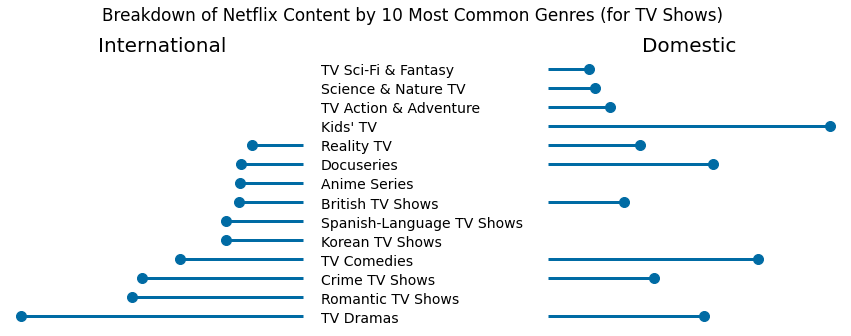

In [87]:
# create figure with shared y-axis
fig, ax = plt.subplots(ncols = 2, sharey = True)

# Create a lolipop chart because why not!

# stem of the sub-plot 1
ax[0].hlines(final_results["Genres"], 
             xmin = 0,
             xmax = -1 * final_results["support_x"],
             lw = 3)
# dot of the sub-plot 1
ax[0].scatter(-1 * final_results["support_x"], 
              final_results["Genres"],
              marker = "o", 
              s = 100)

# shift the y-axis to right for sub-plot 1 to make the yticklabels appear in center
ax[0].yaxis.tick_right() 
# enable yticks
ax[0].set_yticks(final_results["Genres"].index)
# enable yticklabels
ax[0].set_yticklabels(list(final_results["Genres"].values)) #, fontdict = {'horizontalalignment': "center"})
# hide ytickmarks
ax[0].tick_params(axis = u'y', which = u'both', length=0)

# title for sub-plot 1
ax[0].set_title("International")
# hide the x-axis
ax[0].get_xaxis().set_visible(False)


# stem of the sub-plot 2
ax[1].hlines(final_results["Genres"], 
             xmin = 0,
             xmax = final_results["support_y"], 
             lw = 3)
# dot of the sub-plot 2
ax[1].scatter(final_results["support_y"], 
              final_results["Genres"],
              marker = "o", 
              s = 100)

# title for sub-plot 2
ax[1].set_title("Domestic")
# hide tick marks for y-axis
ax[1].tick_params(axis = 'y', which = u'both', length=0)
# hide the x-axis for sub-plot 2
ax[1].get_xaxis().set_visible(False)


# despine the sub-plot 
for i in ax[0].spines:
    ax[0].spines[i].set_visible(False)
for i in ax[1].spines:
    ax[1].spines[i].set_visible(False)

# extras     
plt.subplots_adjust(wspace = 0.7)
plt.suptitle("Breakdown of Netflix Content by 10 Most Common Genres (for TV Shows)", y = 1.02)

# show the plot
plt.show()

In [88]:
# calculate support values for international Movie content
apriori_results = calculate_association(inter_mv, "listed_in", 0.05, 2)
apriori_results

,support,itemsets
6,1.000,(International Movies)
3,0.532,(Dramas)
16,0.532,"(Dramas, International Movies)"
1,0.300,(Comedies)
12,0.300,"(Comedies, International Movies)"
0,0.145,(Action & Adventure)
10,0.145,"(Action & Adventure, International Movies)"
21,0.135,"(Romantic Movies, International Movies)"
8,0.135,(Romantic Movies)
14,0.107,"(Documentaries, International Movies)"


In [89]:
# display association rules and values for international TV content
rules_df = association_rules(apriori_results, metric="lift").sort_values(by = ["antecedent support", "lift", "support"],
                                                                         ascending = False)[:9]
rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(International Movies),(Dramas),1.000,0.532,0.532,0.532,1.000,0.000,1.000
3,(International Movies),(Comedies),1.000,0.300,0.300,0.300,1.000,0.000,1.000
5,(International Movies),(Action & Adventure),1.000,0.145,0.145,0.145,1.000,0.000,1.000
7,(International Movies),(Romantic Movies),1.000,0.135,0.135,0.135,1.000,0.000,1.000
9,(International Movies),(Documentaries),1.000,0.107,0.107,0.107,1.000,0.000,1.000
11,(International Movies),(Independent Movies),1.000,0.102,0.102,0.102,1.000,0.000,1.000
13,(International Movies),(Thrillers),1.000,0.094,0.094,0.094,1.000,0.000,1.000
17,(International Movies),(Music & Musicals),1.000,0.067,0.067,0.067,1.000,0.000,1.000
23,(International Movies),(Horror Movies),1.000,0.050,0.050,0.050,1.000,0.000,1.000


In [90]:
# result dataframe
final_results = pd.DataFrame({"Genres" : rules_df["consequents"].apply(lambda s: list(s)[0]), 
                              "support" : rules_df["support"]})
final_results

,Genres,support
1,Dramas,0.532
3,Comedies,0.300
5,Action & Adventure,0.145
7,Romantic Movies,0.135
9,Documentaries,0.107
11,Independent Movies,0.102
13,Thrillers,0.094
17,Music & Musicals,0.067
23,Horror Movies,0.050


In [91]:
# calculate support values for domestic Movie content
apriori_results = calculate_association(domestic_mv, "listed_in", 0.05, 1)[:10]

apriori_results.rename({"itemsets" : "Genres"}, axis = 1, inplace = True)

apriori_results["Genres"] = apriori_results["Genres"].apply(lambda s: list(s)[0])

In [92]:
# merge the final results of both the domestic and international TV content
final_results = final_results.merge(apriori_results[["Genres", "support"]], 
                                    how = "outer", 
                                    left_on = "Genres", 
                                    right_on = "Genres")
final_results

,Genres,support_x,support_y
0,Dramas,0.532,0.276
1,Comedies,0.300,0.252
2,Action & Adventure,0.145,0.125
3,Romantic Movies,0.135,0.069
4,Documentaries,0.107,0.178
5,Independent Movies,0.102,0.144
6,Thrillers,0.094,0.089
7,Music & Musicals,0.067,NaN
8,Horror Movies,0.050,0.065
9,Children & Family Movies,NaN,0.175


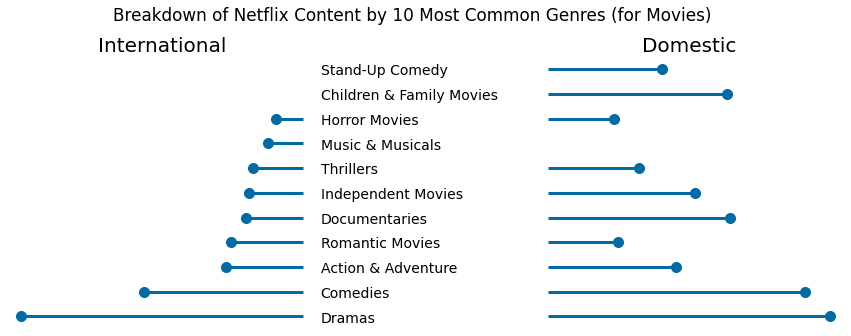

In [93]:
# create figure with shared y-axis
fig, ax = plt.subplots(ncols = 2, sharey = True)

# Create a lolipop chart because why not!

# stem of the sub-plot 1
ax[0].hlines(final_results["Genres"], 
             xmin = 0,
             xmax = -1 * final_results["support_x"],
             lw = 3)
# dot of the sub-plot 1
ax[0].scatter(-1 * final_results["support_x"], 
              final_results["Genres"],
              marker = "o", 
              s = 100)

# shift the y-axis to right for sub-plot 1 to make the yticklabels appear in center
ax[0].yaxis.tick_right() 
# enable yticks
ax[0].set_yticks(final_results["Genres"].index)
# enable yticklabels
ax[0].set_yticklabels(list(final_results["Genres"].values)) #, fontdict = {'horizontalalignment': "center"})
# hide ytickmarks
ax[0].tick_params(axis = u'y', which = u'both', length=0)

# title for sub-plot 1
ax[0].set_title("International")
# hide the x-axis
ax[0].get_xaxis().set_visible(False)


# stem of the sub-plot 2
ax[1].hlines(final_results["Genres"], 
             xmin = 0,
             xmax = final_results["support_y"], 
             lw = 3)
# dot of the sub-plot 2
ax[1].scatter(final_results["support_y"], 
              final_results["Genres"],
              marker = "o", 
              s = 100)

# title for sub-plot 2
ax[1].set_title("Domestic")
# hide tick marks for y-axis
ax[1].tick_params(axis = 'y', which = u'both', length=0)
# hide the x-axis for sub-plot 2
ax[1].get_xaxis().set_visible(False)


# despine the sub-plot 
for i in ax[0].spines:
    ax[0].spines[i].set_visible(False)
for i in ax[1].spines:
    ax[1].spines[i].set_visible(False)

# extras     
plt.subplots_adjust(wspace = 0.7)
plt.suptitle("Breakdown of Netflix Content by 10 Most Common Genres (for Movies)", y = 1.02)

# show the plot
plt.show()

## Compare English Language vs. Non-English Language Content

In [94]:
# read the source wikipedia page
response = requests.get("https://en.wikipedia.org/wiki/List_of_countries_and_territories_where_English_is_an_official_language")

# parse the response content as html
soup = BeautifulSoup(response.content, "html.parser")

In [95]:
# read the first table with primarily English Speaking Countires
df = pd.read_html(str(soup.find_all("table")[0]))[0]

# tranform the dataframe to a list
english_countries = list(df["Country"].str.extract("(\w+\s*\w+)")[0].values)

# print the extracted countries
# print(english_countries)

# read the second table with Multi-Language Speaking Countires
df = pd.read_html(str(soup.find_all("table")[1]))[0]

# Filter the countries where English is a primary language and add to the list from above step
english_countries = english_countries + list(df.loc[df["Primary language?"].str.contains("Yes"), 
                                                    "Country"].str.replace("\[\d+\]", "", regex = True).values)
# print the final list
# english_countries

In [96]:
# make a copy of cleaned dataframe to avoid warnings
netflix_clean_data = netflix_clean_data.copy() 

# Based on the english speaking countries, segregate the titles into English/Non-English categories
netflix_clean_data["prim_lang"] = netflix_clean_data["country"].apply(lambda s: "E" if s.split(",")[0]
                                                                      in english_countries
                                                                      else ("U" if s.split(",")[0] == "Unknown" 
                                                                             else "NE"))

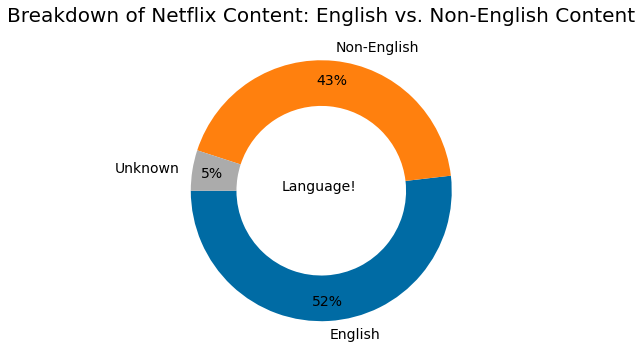

In [97]:
# plot the distribution
fig, ax = plt.subplots(figsize = (15, 6))

# donut chart for breakdown of content by primary language
ax.pie(x = netflix_clean_data["prim_lang"].value_counts(), 
       labels = ["English", "Non-English", "Unknown"], 
       wedgeprops={'width':0.35}, 
       autopct = "%.0f%%", 
       pctdistance = 0.85, 
       startangle = 180)

# extras
ax.text(-0.3, 0, "Language!")
ax.set_title("Breakdown of Netflix Content: English vs. Non-English Content") #, fontsize = "small")

# show the plot
plt.show()

In [98]:
# calculate the most credited cast members for English Content
apriori_results_eng = calculate_association(netflix_clean_data[(netflix_clean_data["cast"] != "Unknown") & 
                                                           (netflix_clean_data["prim_lang"] == "E")],
                                        "cast", 0.001, 1)

# top 10 most credited cast members for English Content
apriori_results_eng[:10]

,support,itemsets
694,0.006,(John Cleese)
11,0.005,(Adam Sandler)
1322,0.005,(Tara Strong)
1058,0.005,(Nicolas Cage)
105,0.005,(Ashleigh Ball)
343,0.005,(David Attenborough)
481,0.005,(Fred Tatasciore)
1236,0.005,(Samuel L. Jackson)
1409,0.004,(Vincent Tong)
68,0.004,(Andrea Libman)


In [99]:
# calculate the most credited cast members for Non-English Content
apriori_results_neng = calculate_association(netflix_clean_data[(netflix_clean_data["cast"] != "Unknown") & 
                                                           (netflix_clean_data["prim_lang"] == "NE")],
                                        "cast", 0.001, 1)

# top 10 most credited cast members for Non-English Content
apriori_results_neng[:10]

,support,itemsets
81,0.012,(Anupam Kher)
743,0.010,(Shah Rukh Khan)
562,0.009,(Naseeruddin Shah)
32,0.009,(Akshay Kumar)
55,0.008,(Amitabh Bachchan)
598,0.008,(Paresh Rawal)
590,0.008,(Om Puri)
820,0.008,(Takahiro Sakurai)
912,0.008,(Yuki Kaji)
394,0.008,(Kareena Kapoor)


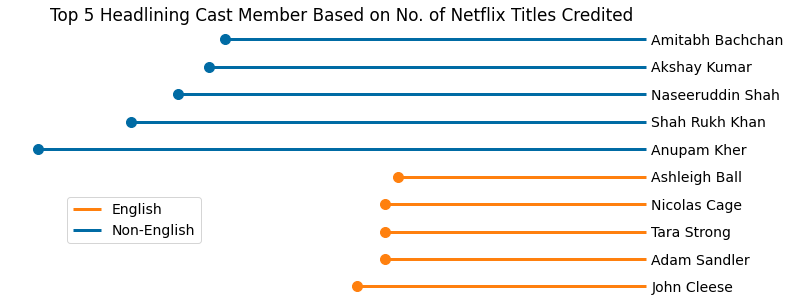

In [100]:
# plot the Top 5 Most credited cast members for English & Non-English Content
fig, ax = plt.subplots(figsize = (12, 5)) 

# stems
ax.hlines(y = apriori_results_eng[:5]["itemsets"].apply(lambda s: list(s)[0]),
          xmin = 0,
          xmax = -1 * apriori_results_eng[:5]["support"],
          lw = 3, 
          color = "#FF800E", 
          label = "English")
# dots
ax.scatter(y = apriori_results_eng[:5]["itemsets"].apply(lambda s: list(s)[0]),
           x = -1 * apriori_results_eng[:5]["support"],
           color = "#FF800E",
           s = 100)
# stems
ax.hlines(apriori_results_neng[:5]["itemsets"].apply(lambda s: list(s)[0]),
          xmin = 0,
          xmax = -1 * apriori_results_neng[:5]["support"],
          lw = 3,
          label = "Non-English")
# dots
ax.scatter(y = apriori_results_neng[:5]["itemsets"].apply(lambda s: list(s)[0]),
           x = -1 * apriori_results_neng[:5]["support"], 
           s = 100)

# annotations
for i in range(5):
    ax.annotate(text = apriori_results_eng[:5]["itemsets"].apply(lambda s: list(s)[0]).values[i],
                   xy = (0.0001, i - 0.2))
for i in range(5):
    ax.annotate(text = apriori_results_neng[:5]["itemsets"].apply(lambda s: list(s)[0]).values[i],
                   xy = (0.0001, (i + 5) - 0.2))

# extras    
ax.set_title("Top 5 Headlining Cast Member Based on No. of Netflix Titles Credited", fontsize = "large")
ax.axis("off")
ax.legend(bbox_to_anchor = (0.3, 0.4))

# display the plot
plt.show()

In [101]:
# identify the most credited directors for Non-English Content
apriori_results_neng = calculate_association(netflix_clean_data[(netflix_clean_data["director"] != "Unknown") & 
                                                           (netflix_clean_data["prim_lang"] == "NE")],
                                        "director", 0.001, 1)

# top 10 most credited directors for Non-English Content
apriori_results_neng[:10]

,support,itemsets
61,0.007,(Jan Suter)
119,0.006,(Raúl Campos)
25,0.005,(Cathy Garcia-Molina)
154,0.004,(Youssef Chahine)
34,0.003,(David Dhawan)
18,0.003,(Anurag Kashyap)
155,0.003,(Yılmaz Erdoğan)
62,0.003,(Johnnie To)
142,0.003,(Umesh Mehra)
50,0.003,(Hakan Algül)


In [102]:
# calculate the most credited directors for English Content
apriori_results_eng = calculate_association(netflix_clean_data[(netflix_clean_data["director"] != "Unknown") & 
                                                           (netflix_clean_data["prim_lang"] == "E")],
                                        "director", 0.001, 1)
# top 10 most credited directors for English Content
apriori_results_eng[:10]

,support,itemsets
33,0.005,(Marcus Raboy)
15,0.005,(Jay Karas)
35,0.004,(Martin Scorsese)
14,0.004,(Jay Chapman)
64,0.003,(Steven Spielberg)
22,0.003,(Justin G. Dyck)
56,0.003,(Shannon Hartman)
50,0.002,(Robert Rodriguez)
29,0.002,(Leslie Small)
25,0.002,(Kunle Afolayan)


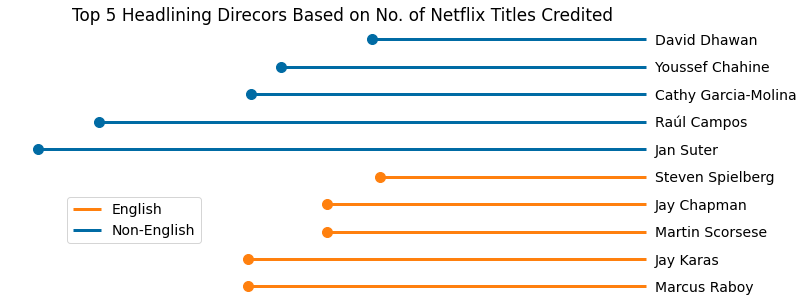

In [103]:
# plot the Top 5 Most credited Directors for English & Non-English Content
fig, ax = plt.subplots(figsize = (12, 5)) 

# stems
ax.hlines(y = apriori_results_eng[:5]["itemsets"].apply(lambda s: list(s)[0]),
          xmin = 0,
          xmax = -1 * apriori_results_eng[:5]["support"],
          lw = 3, 
          color = "#FF800E", 
          label = "English")
# dots
ax.scatter(y = apriori_results_eng[:5]["itemsets"].apply(lambda s: list(s)[0]),
           x = -1 * apriori_results_eng[:5]["support"],
           color = "#FF800E",
           s = 100)

# stems
ax.hlines(apriori_results_neng[:5]["itemsets"].apply(lambda s: list(s)[0]),
          xmin = 0,
          xmax = -1 * apriori_results_neng[:5]["support"],
          lw = 3, 
          label = "Non-English")
# dots
ax.scatter(y = apriori_results_neng[:5]["itemsets"].apply(lambda s: list(s)[0]),
           x = -1 * apriori_results_neng[:5]["support"], 
           s = 100)

# annotations
for i in range(5):
    ax.annotate(text = apriori_results_eng[:5]["itemsets"].apply(lambda s: list(s)[0]).values[i],
                   xy = (0.0001, i - 0.2))
for i in range(5):
    ax.annotate(text = apriori_results_neng[:5]["itemsets"].apply(lambda s: list(s)[0]).values[i],
                   xy = (0.0001, (i + 5) - 0.2))

# extras    
ax.set_title("Top 5 Headlining Direcors Based on No. of Netflix Titles Credited", fontsize = "large")
ax.axis("off")
ax.legend(bbox_to_anchor = (0.3, 0.4))

# show the plot
plt.show()

In [104]:
# import wordcloud, stopwords and Image modules
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [105]:
# to collect all the STOPWORDS
stopwords = set(STOPWORDS)

In [106]:
# to collect all the words from description column of Non-English Content 
title_words_ne = ""

"""
- select the descriptions from the rows classified as Non-English Content
- remove any non-alpha-numeric characters from the description of a title
- collect each word from each row of description column
- join all the words to obtain a string collection
"""
# format the description column for Non-English Content
for row in netflix_clean_data[netflix_clean_data["prim_lang"] == "NE"]["description"].str.replace(pat = r"[^a-zA-Z0-9 ]", 
                                                                                       repl = "", 
                                                                                       regex = True):
    # split the words by space for each row
    for each_word in row.split():
        # collect all the words in string object
        title_words_ne += "".join(each_word.lower())+" "

In [107]:
# to collect all the words from description column of English Content 
title_words_e = ""

"""
- select the descriptions from the rows classified as Non-English Content
- remove any non-alpha-numeric characters from the description of a title
- collect each word from each row of description column
- join all the words to obtain a string collection
"""
# format the description column for English Content
for row in netflix_clean_data[netflix_clean_data["prim_lang"] == "E"]["description"].str.replace(pat = r"[^a-zA-Z0-9 ]", 
                                                                                       repl = "", 
                                                                                       regex = True):
    # split the words by space for each row
    for each_word in row.split():
        # collect all the words in string object
        title_words_e += "".join(each_word.lower())+" "

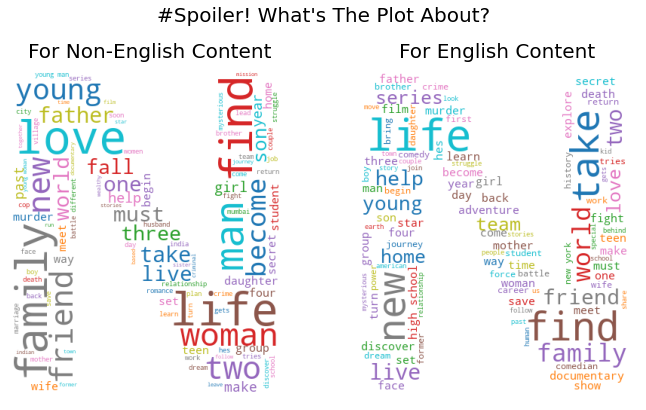

In [108]:
# plot the wordclouds
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

# to obtain the wordcloud in the shape of N
mask = np.array(Image.open("Netflix_icon2.png"))

# set the properties for and generate the word cloud for Non-English Content
wrd = WordCloud(mask = mask, 
                stopwords = stopwords, 
                background_color = "white", 
                max_words = 100, 
                colormap = "tab10_r", 
                random_state = 1).generate(title_words_ne)

# plot the word cloud
ax[0].imshow(wrd)
# extras
ax[0].axis("off")
ax[0].set_title("For Non-English Content")

# set the properties for and generate the word cloud for English Content
wrd = WordCloud(mask = mask, 
                stopwords = stopwords, 
                background_color = "white", 
                max_words = 100, 
                colormap = "tab10_r", 
                random_state = 1).generate(title_words_e)

# plot the word cloud
ax[1].imshow(wrd)
# extras
ax[1].axis("off")
ax[1].set_title("For English Content")
plt.tight_layout(pad = 0)
plt.suptitle("#Spoiler! What's The Plot About?", y = 1.1, fontsize = 20)

# show the plot
plt.show()